#### Classification | Model

# Predicting Heart Disease  

### Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exploratory Data Analysis](#3)<br/>
   [Data Summary](#31)<br/>
   [Classification Viability](#32)<br/>
   [Classification Metrics](#33)<br/>
4. [Baseline](#4)<br/>
5. [Validation](#5)<br/>
6. [Model Iterations](#6) <br/>
    1 [Dummy Classifier](#61)<br/>
    2 [Logistic Regression](#62)<br/>
    3 [Decision Trees: Depth 2](#63)<br/>
    4 [Decision Trees: Depth 4](#64)<br/>
    5 [Random Forests](#65)<br/>
    6 [Gradient Boosted Trees: xgboost](#66)<br/>
    7 [Naive Bayes: Bernoulli](#67)<br/>
    8 [Naive Bayes: Gaussian](#68)<br/>
    9 [Naive Bayes: Multinomial](#69)<br/>
    10 [Ensemble:  Naive Bayes Hard Voting Classifier](#610)<br/>
    11 [Ensemble:  Naive Bayes Soft Voting Classifier](#611)<br/>
    12 [Ensemble:  Stacking Classifier (non-NBs)](#612)<br/>
    [Feature Engineering](#fe)<br/>
    13 [Logistic regression: Question groups](#613)<br/>
    14 [Logistic regression: Risk factors](#614)<br/>
    15 [Logistic regression: Question groups + Risk factor features](#615)<br/>
    [Class Imbalance Handling](#cih)<br/>
    16 [Logistic regression: threshold = 0.05](#616)<br/>
    [Model Tuning: GridSearchCV](#gscv)<br/>
    17 [Logistic regression: GridSearchCV](#617)<br/>
    18 [Logistic regression: GridSearchCV + threshold = 0.05](#618)<br/>
7. [Model: Predicting Heart Disease ](#7)<br/>
    [Test Model](#71)<br/>
    [Confusion Matrix](#72)<br/>
    [ROC AUC (X, y)](#73) <br/>
    [Feature Correlations](#74) <br/>
    [Predictions](#75)


In [1]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import dataframe_image as dfi
import pickle
import warnings
warnings.filterwarnings("ignore")
# import plotly.express as px
# import plotly.graph_objects as go
                        
plt.style.use('ggplot')
%matplotlib inline
sns.set_style("whitegrid")

np.set_printoptions(suppress=True)

from mlxtend.classifier import StackingClassifier
from plotly.subplots import make_subplots           
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# 1 | Research Design<a id='1'></a> 

* **Research Question:** What model can best predict patients' risk for heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>
_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

[back to top](#top)

# 2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


In [2]:
# load clean and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('data/heart_disease_df.csv')
heart_disease_df_map = pd.read_csv('data/heart_disease_df_map.csv') 


In [3]:
# clean df
heart_disease_df.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,Yes,No,5.0,Yes,55-59,Female,White,Yes,Yes,No,Yes,No,16.60,Very good,30.0,No,3.0,No
1,Yes,No,7.0,No,80 or older,Female,White,No,No,No,No,Yes,20.34,Very good,0.0,No,0.0,No
2,Yes,No,8.0,Yes,65-69,Male,White,Yes,Yes,No,No,No,26.58,Fair,30.0,No,20.0,No


In [4]:
# transformed df: mapped categorical variables to numerical values 
heart_disease_df_map.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0


[back to top](#top)

# 3 | Exploratory Data Analysis<a id='3'></a> 

#### Using `heart_disease_df_map` with mapped variables for modeling.
##### Note: Full EDA part of [MVP](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).

### 3.1 Data Summary<a id='31'></a> 

In [5]:
# dataframe info
heart_disease_df_map.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  int64  
 1   behavior_alcohol   319795 non-null  int64  
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  int64  
 4   demg_age           319795 non-null  int64  
 5   demg_gender        319795 non-null  int64  
 6   demg_race          319795 non-null  int64  
 7   disease_asthma     319795 non-null  int64  
 8   disease_diabetes   319795 non-null  int64  
 9   disease_kidney     319795 non-null  int64  
 10  disease_skin       319795 non-null  int64  
 11  disease_stroke     319795 non-null  int64  
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  int64  
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  int64  
 16  he

#### No missing data, all data types are numerical.

[back to top](#top)

### 3.2 Classification Viability<a id='32'></a> 

In [6]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')


,count,mean,std,min,25%,50%,75%,max
behavior_activity,319795.000000,0.775362,0.417344,0.000000,1.000000,1.000000,1.000000,1.000000
behavior_alcohol,319795.000000,0.068097,0.251912,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_sleep,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000
behavior_tobacco,319795.000000,0.412477,0.492281,0.000000,0.000000,0.000000,1.000000,1.000000
demg_age,319795.000000,52.440945,18.069747,18.000000,40.000000,55.000000,65.000000,80.000000
demg_gender,319795.000000,1.475273,0.499389,1.000000,1.000000,1.000000,2.000000,2.000000
demg_race,319795.000000,5.396742,1.212208,1.000000,6.000000,6.000000,6.000000,6.000000
disease_asthma,319795.000000,0.134061,0.340718,0.000000,0.000000,0.000000,0.000000,1.000000
disease_diabetes,319795.000000,0.207205,0.554528,0.000000,0.000000,0.000000,0.000000,3.000000
disease_kidney,319795.000000,0.036833,0.188352,0.000000,0.000000,0.000000,0.000000,1.000000


In [7]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
behavior_activity,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283,-0.100030
behavior_alcohol,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254,-0.032080
behavior_sleep,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387,0.008327
behavior_tobacco,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352,0.107764
demg_age,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789,0.232325
demg_gender,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904,0.070040
demg_race,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847,0.034854
disease_asthma,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907,0.041444
disease_diabetes,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644,0.118281
disease_kidney,-0.081827,-0.028280,0.006238,0.034920,0.122697,-0.009084,0.003709,0.039707,0.095186,1.000000,0.061816,0.091167,0.050768,-0.174642,0.037281,0.153064,0.142197,0.145197


In [8]:
# correlation matrix subset
heart_disease_df_map[['y_heart_disease', 'demg_age', 'behavior_tobacco','health_physical', 'health_mobility', 'disease_diabetes','disease_kidney','disease_stroke',]].corr().style.background_gradient(cmap='Blues')


,y_heart_disease,demg_age,behavior_tobacco,health_physical,health_mobility,disease_diabetes,disease_kidney,disease_stroke
y_heart_disease,1.000000,0.232325,0.107764,0.170721,0.201258,0.118281,0.145197,0.196835
demg_age,0.232325,1.000000,0.130384,0.110789,0.242552,0.154070,0.122697,0.137280
behavior_tobacco,0.107764,0.130384,1.000000,0.115352,0.120074,0.038993,0.034920,0.061226
health_physical,0.170721,0.110789,0.115352,1.000000,0.428373,0.111644,0.142197,0.137014
health_mobility,0.201258,0.242552,0.120074,0.428373,1.000000,0.152876,0.153064,0.174143
disease_diabetes,0.118281,0.154070,0.038993,0.111644,0.152876,1.000000,0.095186,0.072476
disease_kidney,0.145197,0.122697,0.034920,0.142197,0.153064,0.095186,1.000000,0.091167
disease_stroke,0.196835,0.137280,0.061226,0.137014,0.174143,0.072476,0.091167,1.000000


#### A classification model is viable.

[back to top](#top)

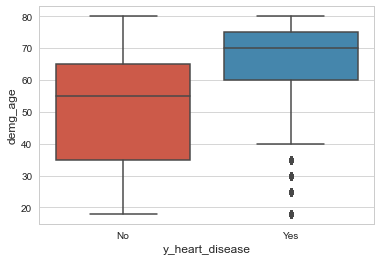

In [9]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


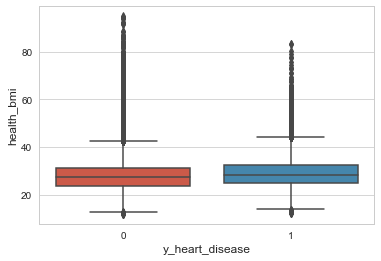

In [10]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


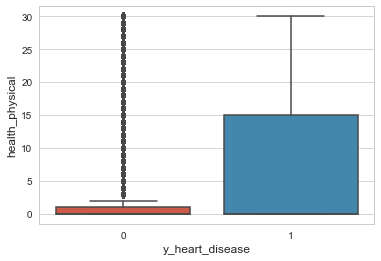

In [11]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [12]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


Positives/Negatives Ratio: 9.36 %
No     292422
Yes     27373
Name: y_heart_disease, dtype: int64


[back to top](#top)

### 3.3 Classification Metrics<a id='33'></a> 

* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients. 

[back to top](#top)

# 4 | Baseline<a id='4'></a> 

#### Logistic regression with three features based on correlation matrix.

In [13]:
# separate target from features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease'] 
X_base = heart_disease_df_map.loc[:, [
#     'behavior_activity', 
#     'behavior_alcohol', 
#     'behavior_sleep',
#     'behavior_tobacco',
    'demg_age',
#     'demg_gender', 
#     'demg_race',
#     'disease_asthma', 
#     'disease_diabetes', 
#     'disease_kidney', 
#     'disease_skin', 
#     'disease_stroke', 
#     'health_bmi', 
#     'health_general', 
#     'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split baseline data test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,
                                                                        y_base,
                                                                        test_size=0.2,
                                                                        random_state=42)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base, 
                                                                                y_train_base, 
                                                                                test_size = .25, 
                                                                                random_state = 42)

# scale baseline X train/test
scaler = StandardScaler()
X_train_scaled_base = scaler.fit_transform(X_train_base)
X_test_scaled_base = scaler.transform(X_test_base)
X_val_scaled_base = scaler.transform(X_val_base)


In [14]:
# baseline logistic regression X train scaled & y train
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m 
y_pred_base = log_reg_base.predict(X_val_scaled_base) 

In [15]:
# score on recall and roc auc
zero = ["Baseline logistic regression", 'log_reg_base',
        recall_score(y_val_base, y_pred_base),
        roc_auc_score(y_val_base, log_reg_base.predict_proba(X_val_scaled_base)[:,1])]
zero

['Baseline logistic regression',
 'log_reg_base',
 0.02132701421800948,
 0.7858257042010828]

[back to top](#top)

# 5 | Validation<a id='5'></a>

#### Validation and testing scheme to use in [model selection](#7). 

In [16]:
# separate target from features 
y = heart_disease_df_map['y_heart_disease'] 
X = heart_disease_df_map.loc[:, [
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split data test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                            y_train, 
                                                            test_size = .25, 
                                                            random_state = 42)

# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X) 


[back to top](#top)

# 6 | Model Iterations <a id='6'></a> 

### 6.1 Dummy Classifier<a id='61'></a> 

In [17]:
clf = DummyClassifier(strategy= 'most_frequent')
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_val)


In [18]:
one = ["Dummy classifier", 'clf',
         recall_score(y_val, y_pred_clf), 
         roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])]
one

['Dummy classifier', 'clf', 0.0, 0.5]

#### Dummy classifier performed worse than [baseline](#4).<br/>

[back to top](#top)

### 6.2 Logistic Regression<a id='62'></a> 

In [19]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled) 


In [20]:
two = ["Logistic regression", 'log_reg',
       recall_score(y_val, y_pred_log_reg), 
       roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])]
two

['Logistic regression', 'log_reg', 0.0995260663507109, 0.8411422086561615]

#### Logistic regression (with all features) performed better than [baseline](#4).<br/>

In [21]:
# confusion matrix for log_reg

cm_log_reg = confusion_matrix(y_val, y_pred_log_reg)
cm_log_reg


array([[57968,   505],
       [ 4940,   546]])

[back to top](#top)

### 6.3 Decision Trees: Depth 2<a id='63'></a> 

In [22]:
dt_2 = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_2.fit(X_train, y_train)
y_pred_dt_2 = dt_2.predict(X_val)


In [23]:
three = ["Decision tree (depth=2)", 'dt_2', 
       recall_score(y_val, y_pred_dt_2), 
       roc_auc_score(y_val, dt_2.predict_proba(X_val)[:,1])]
three

['Decision tree (depth=2)', 'dt_2', 0.0, 0.7653574312653932]

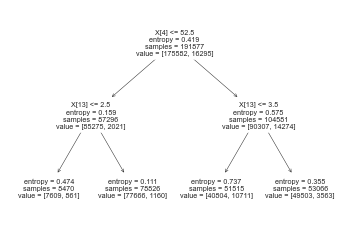

In [24]:
tree.plot_tree(dt_2);

### 6.4 Decision Trees: Depth 4<a id='64'></a> 

In [25]:
dt_4 = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt_4.fit(X_train, y_train)
y_pred_dt_4 = dt_4.predict(X_val)


In [26]:
four = ["Decision tree (depth=4)", 'dt_4',
         recall_score(y_val, y_pred_dt_4),
         roc_auc_score(y_val, dt_4.predict_proba(X_val)[:,1])]
four

['Decision tree (depth=4)', 'dt_4', 0.0, 0.8112940974985579]

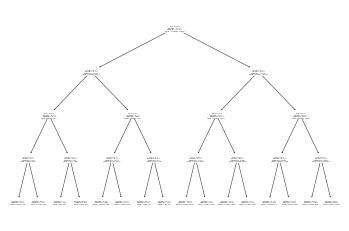

In [27]:
tree.plot_tree(dt_4);

#### Decision trees performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.5 Random Forests <a id='65'></a> 

In [28]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_forest = forest.predict(X_val)


In [29]:
five = ["Random forest", 'forest',
        recall_score(y_val, y_pred_forest),
        roc_auc_score(y_val, forest.predict_proba(X_val)[:,1])]
five

['Random forest', 'forest', 0.11593146190302589, 0.7977091283531662]

#### Random forest performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.6 Gradient Boosted Trees: xgboost<a id='66'></a> 

In [30]:
# XGBoost

gbm = xgb.XGBRegressor( 
                    n_estimators=30000,
                    max_depth=3,
                    objective="binary:logistic",
                    eval_metric='auc',
                    learning_rate=.1,
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8
                    )

eval_set=[(X_train, y_train),(X_val,y_val)] 

gbm_fit = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
#                     eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False 
                   )

#### [220]	validation_0-auc: 0.84848	validation_1-auc: 0.84449


In [31]:
y_pred_gbm = gbm.predict(X_val)
y_pred_gbm

array([0.00727439, 0.02875089, 0.1310833 , ..., 0.00484608, 0.12610735,
       0.00575493], dtype=float32)

In [32]:
six = ["XGBoost", 'gbm',
        recall_score(y_val, np.round(gbm.predict(X_val))), 
        roc_auc_score(y_val, np.round(gbm.predict(X_val)))]
six


['XGBoost', 'gbm', 0.08494349252643091, 0.5390770170719649]

#### XGBoost performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.7. Naive Bayes: Bernoulli<a id='67'></a> 

In [33]:
# BernoulliNB() 
bern = BernoulliNB().fit(X_train, y_train)
y_predict_bern = bern.predict(X_val) 


In [34]:
seven = ["Bernoulli NB", 'bern',
       recall_score(y_val, y_predict_bern),
       roc_auc_score(y_val, bern.predict_proba(X_val)[:,1])]

seven

['Bernoulli NB', 'bern', 0.22748815165876776, 0.7624059816559161]

### 6.8. Naive Bayes: Gaussian<a id='68'></a> 

In [35]:
gaus = GaussianNB().fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_val)


In [36]:
eight = ["Gaussian NB",'gaus',
         recall_score(y_val, y_pred_gaus),
         roc_auc_score(y_val, gaus.predict_proba(X_val)[:,1])]
eight

['Gaussian NB', 'gaus', 0.47101713452424354, 0.8053429818657589]

### 6.9. Naive Bayes: Multinomial<a id='69'></a> 

In [37]:
multi = MultinomialNB().fit(X_train, y_train)
y_pred_multi = multi.predict(X_val)


In [38]:
nine = ["Multinomial NB", 'multi',
        recall_score(y_val, y_pred_multi),
        roc_auc_score(y_val, multi.predict_proba(X_val)[:,1])]
nine

['Multinomial NB', 'multi', 0.33594604447685017, 0.7628424887440532]

#### Naive Bayes performed worse than [logistic regression](#62). 

[back to top](#top)

### 6.10 Ensemble: Naive Bayes Hard Voting Classifier <a id='610'></a> 

In [39]:
# set up voting classifier ensemble

nb_names = ['bern', 'gaus', 'multi']
nb_vars = [eval(n) for n in nb_names]

nb_list = list(zip(nb_names, nb_vars))
nb_list


[('bern', BernoulliNB()), ('gaus', GaussianNB()), ('multi', MultinomialNB())]

In [40]:
vote_hard = VotingClassifier(estimators= nb_list,
                             voting='hard',
                             n_jobs=-1)
vote_hard.fit(X_train, y_train)
y_pred_hard = vote_hard.predict(X_val)


In [41]:
ten = ["Hard NB Voting Classifier", 'vote_hard',
       recall_score(y_val, y_pred_hard),
       roc_auc_score(y_val, vote_hard.predict(X_val))]
ten

['Hard NB Voting Classifier',
 'vote_hard',
 0.34506015311702515,
 0.6335377211124092]

### 6.11 Ensemble: Naive Bayes Soft Voting Classifier <a id='611'></a> 

In [42]:
vote_soft = VotingClassifier(estimators= nb_list,
                             voting='soft',
                             n_jobs=-1)

vote_soft.fit(X_train, y_train)
y_pred_soft = vote_soft.predict(X_val)


In [43]:
eleven = ["Soft NB Voting Classifier", 'vote_soft',
       recall_score(y_val, y_pred_soft), 
       roc_auc_score(y_val, vote_soft.predict_proba(X_val)[:,1])]
eleven

['Soft NB Voting Classifier',
 'vote_soft',
 0.35727305869485965,
 0.7759019684959619]

#### Voting classifier ensemble of Naive Bayes performed worse than [logistic regression](#62). 

[back to top](#top)

# ⚠️
###  6.12 Ensemble:  Stacking Classifier (non-NBs) <a id='612'></a> 

In [44]:
model_names = ['clf', 'log_reg', 'dt_2', 'dt_4', 'forest', 'gbm']

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))
model_list

[('clf', DummyClassifier(strategy='most_frequent')),
 ('log_reg', LogisticRegression()),
 ('dt_2', DecisionTreeClassifier(criterion='entropy', max_depth=2)),
 ('dt_4', DecisionTreeClassifier(criterion='entropy', max_depth=4)),
 ('forest', RandomForestClassifier()),
 ('gbm',
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=30000,
               n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
               predictor='auto', random_state=0, reg_alpha=0, ...))]

In [45]:
stacked = StackingClassifier(classifiers= model_list, 
                             meta_classifier=LogisticRegression(),
                             use_probas=False) 

In [46]:
# stacked.fit(X_train, y_train)
# y_pred_stack = stacked.predict(X_val)


In [47]:
twelve = ["Stacked", 'stacked',
          'NaN',
#            'recall_score(y_val, y_pred_stack)',
           'NaN',
#           roc_auc_score(y_val, stacked.predict_proba(X_val)[:,1])
          ]
twelve

['Stacked', 'stacked', 'NaN', 'NaN']

#### Stacking ensemble (excluding Naive Bayes) did not run.  


[back to top](#top)

## Feature Engineering <a id='fe'></a> 

### Features: Question groups
Groups of similar survey question questions as defined by [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf).

In [48]:
# 1 behaviors = physical activity days/month + sleep time hrs/day + alcohol + tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +  
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age + gender + race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +  
    heart_disease_df_map['demg_race'])

# 3 disease = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +  
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 (health) measures = bmi + general health + mental + mobility + physical
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +  
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures'],
      dtype='object')

### Features: Risk factors
Heart disease risk factors as outlined by [CDC](https://www.cdc.gov/heartdisease/facts.htm). 

In [49]:
# risk factors = diabetes + bmi + physical activity + alcohol
heart_disease_df_map['risk_factors'] = (
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['health_bmi'] +  
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures', 'risk_factors'],
      dtype='object')

In [50]:
# correlation matrix subset
heart_disease_df_map[['y_heart_disease', 
                      'behaviors', 
                      'demographics',
                      'disease', 
                      'measures', 
                      'risk_factors']].corr().style.background_gradient(cmap='Blues')


,y_heart_disease,behaviors,demographics,disease,measures,risk_factors
y_heart_disease,1.000000,0.009616,0.233874,0.210036,0.119176,0.053805
behaviors,0.009616,1.000000,0.097460,-0.021126,-0.133773,-0.064085
demographics,0.233874,0.097460,1.000000,0.230155,-0.035811,-0.000299
disease,0.210036,-0.021126,0.230155,1.000000,0.205334,0.207090
measures,0.119176,-0.133773,-0.035811,0.205334,1.000000,0.513235
risk_factors,0.053805,-0.064085,-0.000299,0.207090,0.513235,1.000000


### 6.13 Logistic regression: question groups<a id='613'></a> 

In [51]:
# separate target from question groups features: y/X_grp
y_grp = heart_disease_df_map['y_heart_disease'] 
X_grp = heart_disease_df_map.loc[:, ['behaviors', 
                                   'demographics', 
                                   'disease', 
                                   'measures']]

# split data test/train/validate
X_train_grp, X_test_grp, y_train_grp, y_test_grp = train_test_split(X_grp, 
                                                    y_grp, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_grp, X_val_grp, y_train_grp, y_val_grp = train_test_split(X_train_grp, 
                                                                    y_train_grp, 
                                                                    test_size = .25, 
                                                                    random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_scaled = scaler.fit_transform(X_train_grp)
X_test_grp_scaled = scaler.transform(X_test_grp)
X_val_grp_scaled = scaler.transform(X_val_grp)


In [52]:
# LR question groups features
log_reg_grp = LogisticRegression()
log_reg_grp.fit(X_train_grp_scaled, y_train_grp)
y_pred_grp = log_reg_grp.predict(X_val_grp_scaled) 


In [53]:
thirteen = ["Logistic regression group features", 'log_reg_grp',
           recall_score(y_val_grp, y_pred_grp), 
           roc_auc_score(y_val_grp, log_reg_grp.predict_proba(X_val_grp_scaled)[:,1])]
thirteen

['Logistic regression group features',
 'log_reg_grp',
 0.024425811155668976,
 0.7971619825669125]

[back to top](#top)

### 6.14 Logistic regression: risk factors<a id='614'></a> 

In [54]:
# separate target from engineered features: y/X_risk
y_risk = heart_disease_df_map['y_heart_disease'] 
X_risk = heart_disease_df_map.loc[:, ['disease_diabetes',
                                    'health_bmi',
                                    'behavior_activity', 
                                   'behavior_alcohol']]

# split data test/train/validate
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, 
                                                    y_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_risk, X_val_risk, y_train_risk, y_val_risk = train_test_split(X_train_risk, 
                                                                        y_train_risk, 
                                                                        test_size = .25, 
                                                                        random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_risk_scaled = scaler.fit_transform(X_train_risk)
X_test_risk_scaled = scaler.transform(X_test_risk)
X_val_risk_scaled = scaler.transform(X_val_risk)


In [55]:
# LR risk factor features
log_reg_risk = LogisticRegression()
log_reg_risk.fit(X_train_risk_scaled, y_train_risk)
y_pred_risk = log_reg_risk.predict(X_val_risk_scaled) 


In [56]:
fourteen = ["Logistic regression risk factor features", 'log_reg_risk',
            recall_score(y_val_risk, y_pred_risk), 
            roc_auc_score(y_val_risk, log_reg_risk.predict_proba(X_val_risk_scaled)[:,1])]
fourteen

['Logistic regression risk factor features',
 'log_reg_risk',
 0.0,
 0.6459868877415583]

[back to top](#top)

### 6.15 Logistic regression: question groups + risk factor features<a id='615'></a> 

In [57]:
# separate target from question groups + risk factor features: y/X_grp_risk
y_grp_risk = heart_disease_df_map['y_heart_disease'] 
X_grp_risk = heart_disease_df_map.loc[:, [
    'behaviors', 
    'demographics', 
    'disease', 
    'measures',
    'behavior_activity',
    'behavior_alcohol',
    'disease_diabetes',
    'health_bmi'
    ]]

# split data test/train/validate
X_train_grp_risk, X_test_grp_risk, y_train_grp_risk, y_test_grp_risk = train_test_split(X_grp_risk, 
                                                    y_grp_risk, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train_grp_risk, X_val_grp_risk, y_train_grp_risk, y_val_grp_risk = train_test_split(X_train_grp_risk, 
                                                                            y_train_grp_risk, 
                                                                            test_size = .25, 
                                                                            random_state = 42)

# Scale X train/test/validate
scaler = StandardScaler()
X_train_grp_risk_scaled = scaler.fit_transform(X_train_grp_risk)
X_test_grp_risk_scaled = scaler.transform(X_test_grp_risk)
X_val_grp_risk_scaled = scaler.transform(X_val_grp_risk)


In [58]:
# LR question groups + risk factor features
log_reg_grp_risk = LogisticRegression()
log_reg_grp_risk.fit(X_train_grp_risk_scaled, y_train_grp_risk)
y_pred_grp_risk = log_reg_grp_risk.predict(X_val_grp_risk_scaled) 


In [59]:
fifteen = ["Logistic regression question groups + risk factor features", 'log_reg_grp_risk',
            recall_score(y_val_grp_risk, y_pred_grp_risk), 
            roc_auc_score(y_val_grp_risk, log_reg_grp_risk.predict_proba(X_val_grp_risk_scaled)[:,1])]
fifteen

['Logistic regression question groups + risk factor features',
 'log_reg_grp_risk',
 0.032081662413415965,
 0.7997790502397076]

#### Models with feature engineering performed worse than [logistic regression](#62). 

[back to top](#top)

## Class Imblance Handling <a id='cih'></a> 

In [60]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

0    292422
1     27373
Name: y_heart_disease, dtype: int64

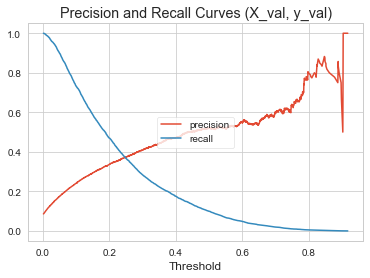

In [61]:
# precision and recall curves for X/y_val
y_pred = log_reg.predict(X_val_scaled) 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_val, log_reg.predict_proba(X_val_scaled)[:,1] )

# f, ax = plt.subplots(figsize=(10, 6))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='center')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves (X_val, y_val)')
plt.savefig("precision-recall-curves.jpeg");

### 6.16 Logistic regression: threshold = 0.05<a id='616'></a> 


In [62]:
# decision threshold = 0.05 based on precision and recall curves
y_predict = (log_reg.predict_proba(X_val_scaled)[:,1] > 0.05)

sixteen = ["Logistic regression threshold = 0.05", 'log_reg',
            recall_score(y_val, y_predict), 
            roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])]
sixteen



# sixteen = {
#     'Model': 'Logistic regression threshold = 0.05', 
#     'Variable': 'log_reg', 
#     'Recall': recall_score(y_val, y_predict) ,
#     'ROC AUC': roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])}
# sixteen

['Logistic regression threshold = 0.05',
 'log_reg',
 0.8993802406124681,
 0.8411422086561615]

#### Model with lower decision threshold performed as well as  [logistic regression](#62).

[back to top](#top)

## Model Tuning: GridSearchCV <a id='gscv'></a> 

### Best Performing Model <a id='bpm'></a> 

In [157]:
# df to summarize 17 model performance

models = [zero, one, two, three, four, five, six, seven, eight, nine, 
          ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen]

model_eval = pd.DataFrame(data = models, columns = ['Model', 
                                                    'Variable', 
                                                    'Recall', 
                                                    'ROC AUC'])
model_eval

,Model,Variable,Recall,ROC AUC
0,Baseline logistic regression,log_reg_base,0.021327,0.785826
1,Dummy classifier,clf,0.0,0.5
2,Logistic regression,log_reg,0.099526,0.841142
3,Decision tree (depth=2),dt_2,0.0,0.765357
4,Decision tree (depth=4),dt_4,0.0,0.811294
5,Random forest,forest,0.115931,0.797709
6,XGBoost,gbm,0.084943,0.539077
7,Bernoulli NB,bern,0.227488,0.762406
8,Gaussian NB,gaus,0.471017,0.805343
9,Multinomial NB,multi,0.335946,0.762842


In [137]:
type(models)

list

In [150]:
models[-1:]

[['Logistic regression threshold = 0.05',
  'log_reg',
  0.8993802406124681,
  0.8411422086561615]]

#### [Logistic regression](#62) performs best on recall and ROC AUC. 

[back to top](#top)

### 6.17 Logistic regression: GridSearchCV<a id='617'></a> 

In [64]:
# find best C params and penalty type
grid={"C": np.logspace(-3,3,7), "penalty":["l1","l2"]}# L1 lasso, L2 ridge
logreg = LogisticRegression()
logregcv = GridSearchCV(logreg, grid, cv=10)
logregcv.fit(X_train,y_train)

print("Tuned Hpyerparameters :(best parameters) ", logregcv.best_params_)
print("Accuracy :", logregcv.best_score_)

Tuned Hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
Accuracy : 0.9158627651711446


In [65]:
# score model on X_val with best GridSearchCV params and threshold = default
log_reg_gridcv = LogisticRegression(C=0.01, penalty="l2")
log_reg_gridcv.fit(X_train_scaled, y_train)

y_pred_log_reg_gridcv = log_reg.predict(X_val_scaled)


In [88]:
seventeen = ['Log reg GridSearchCV + threshold = default',
             'log_reg_gridcv', 
             recall_score(y_val, y_pred_log_reg_gridcv),
             roc_auc_score(y_val, log_reg_gridcv.predict_proba(X_val_scaled)[:,1])]
seventeen

['Log reg GridSearchCV + threshold = default',
 'log_reg_gridcv',
 0.0995260663507109,
 0.8412275311651765]

In [158]:
models.append(seventeen)
models[-1:]

[['Log reg GridSearchCV + threshold = default',
  'log_reg_gridcv',
  0.0995260663507109,
  0.8412275311651765]]

In [161]:
model_eval = pd.DataFrame(data = models, columns = ['Model', 
                                                    'Variable', 
                                                    'Recall', 
                                                    'ROC AUC'])
model_eval

,Model,Variable,Recall,ROC AUC
0,Baseline logistic regression,log_reg_base,0.021327,0.785826
1,Dummy classifier,clf,0.0,0.5
2,Logistic regression,log_reg,0.099526,0.841142
3,Decision tree (depth=2),dt_2,0.0,0.765357
4,Decision tree (depth=4),dt_4,0.0,0.811294
5,Random forest,forest,0.115931,0.797709
6,XGBoost,gbm,0.084943,0.539077
7,Bernoulli NB,bern,0.227488,0.762406
8,Gaussian NB,gaus,0.471017,0.805343
9,Multinomial NB,multi,0.335946,0.762842


### 6.18 Logistic regression: GridSearchCV + threshold = 0.05<a id='618'></a> 

In [79]:
# score model on X_val with best GridSearchCV params and threshold = 0.05
log_reg_gridcv_2 = LogisticRegression(C=0.01, penalty="l2")
log_reg_gridcv_2.fit(X_train_scaled, y_train)
y_pred_log_reg_gridcv_2 = (log_reg_gridcv_2.predict_proba(X_val_scaled)[:,1] > 0.05)


In [90]:
# add model to model_eval df
eighteen = ['Log reg GridSearchCV + threshold =0.05', 
            'log_reg_gridcv_2', 
            recall_score(y_val, y_pred_log_reg_gridcv_2), 
            roc_auc_score(y_val, log_reg_gridcv_2.predict_proba(X_val_scaled)[:,1])]

eighteen

['Log reg GridSearchCV + threshold =0.05',
 'log_reg_gridcv_2',
 0.9010207801676996,
 0.8412275311651765]

In [163]:
models.append(eighteen)
models[-1:]

[['Log reg GridSearchCV + threshold =0.05',
  'log_reg_gridcv_2',
  0.9010207801676996,
  0.8412275311651765]]

#### [Logistic regression GridSearchCV](#616) performs slightly better than [logistic regression](#62). 

[back to top](#top)

# 7 | Model: Predicting Heart Disease  <a id='7'></a> 

#### Model winner: `log_reg_gridcv`

In [164]:
model_eval = pd.DataFrame(data = models, columns = ['Model', 
                                                    'Variable', 
                                                    'Recall', 
                                                    'ROC AUC'])
model_eval

,Model,Variable,Recall,ROC AUC
0,Baseline logistic regression,log_reg_base,0.021327,0.785826
1,Dummy classifier,clf,0.0,0.5
2,Logistic regression,log_reg,0.099526,0.841142
3,Decision tree (depth=2),dt_2,0.0,0.765357
4,Decision tree (depth=4),dt_4,0.0,0.811294
5,Random forest,forest,0.115931,0.797709
6,XGBoost,gbm,0.084943,0.539077
7,Bernoulli NB,bern,0.227488,0.762406
8,Gaussian NB,gaus,0.471017,0.805343
9,Multinomial NB,multi,0.335946,0.762842


In [165]:
model_eval.drop([0,12], inplace=True)
model_eval.sort_values(by=['Recall', 'ROC AUC'], ascending=False).head(5)

,Model,Variable,Recall,ROC AUC
18,Log reg GridSearchCV + threshold =0.05,log_reg_gridcv_2,0.901021,0.841228
16,Logistic regression threshold = 0.05,log_reg,0.89938,0.841142
8,Gaussian NB,gaus,0.471017,0.805343
11,Soft NB Voting Classifier,vote_soft,0.357273,0.775902
10,Hard NB Voting Classifier,vote_hard,0.34506,0.633538


### 7.1 Test Model<a id='71'></a> 

In [73]:
# log_reg = LogisticRegression()
# log_reg.fit(X_train_scaled, y_train)
# y_pred_log_reg = log_reg.predict(X_val_scaled) 

# y_predict = (log_reg.predict_proba(X_val_scaled)[:,1] > 0.05)

# sixteen = ["Logistic regression threshold = 0.05", 'log_reg',
#             recall_score(y_val, y_predict), 
#             roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])]
# sixteen

In [172]:
final_model = LogisticRegression(C=0.01, penalty="l2")
final_model.fit(X_test, y_test)
y_pred = final_model.predict(X_test)
 

final_model_score = {
    'Model': 'Final model on test data', 
    'Variable': 'final_model', 
    'Recall': recall_score(y_test, y_pred) ,
    'ROC AUC': roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1])
}
final_model_score

{'Model': 'Final model on test data',
 'Variable': 'final_model',
 'Recall': 0.10389842632331903,
 'ROC AUC': 0.8265491571106245}

[back to top](#top)

### 7.2 Confusion Matrix<a id='72'></a> 

In [173]:
# y_pred_t = (final_model.predict_proba(X_test)[:,1] > 0.05)

cm = confusion_matrix(y_test, y_pred)
cm

array([[57829,   538],
       [ 5011,   581]])

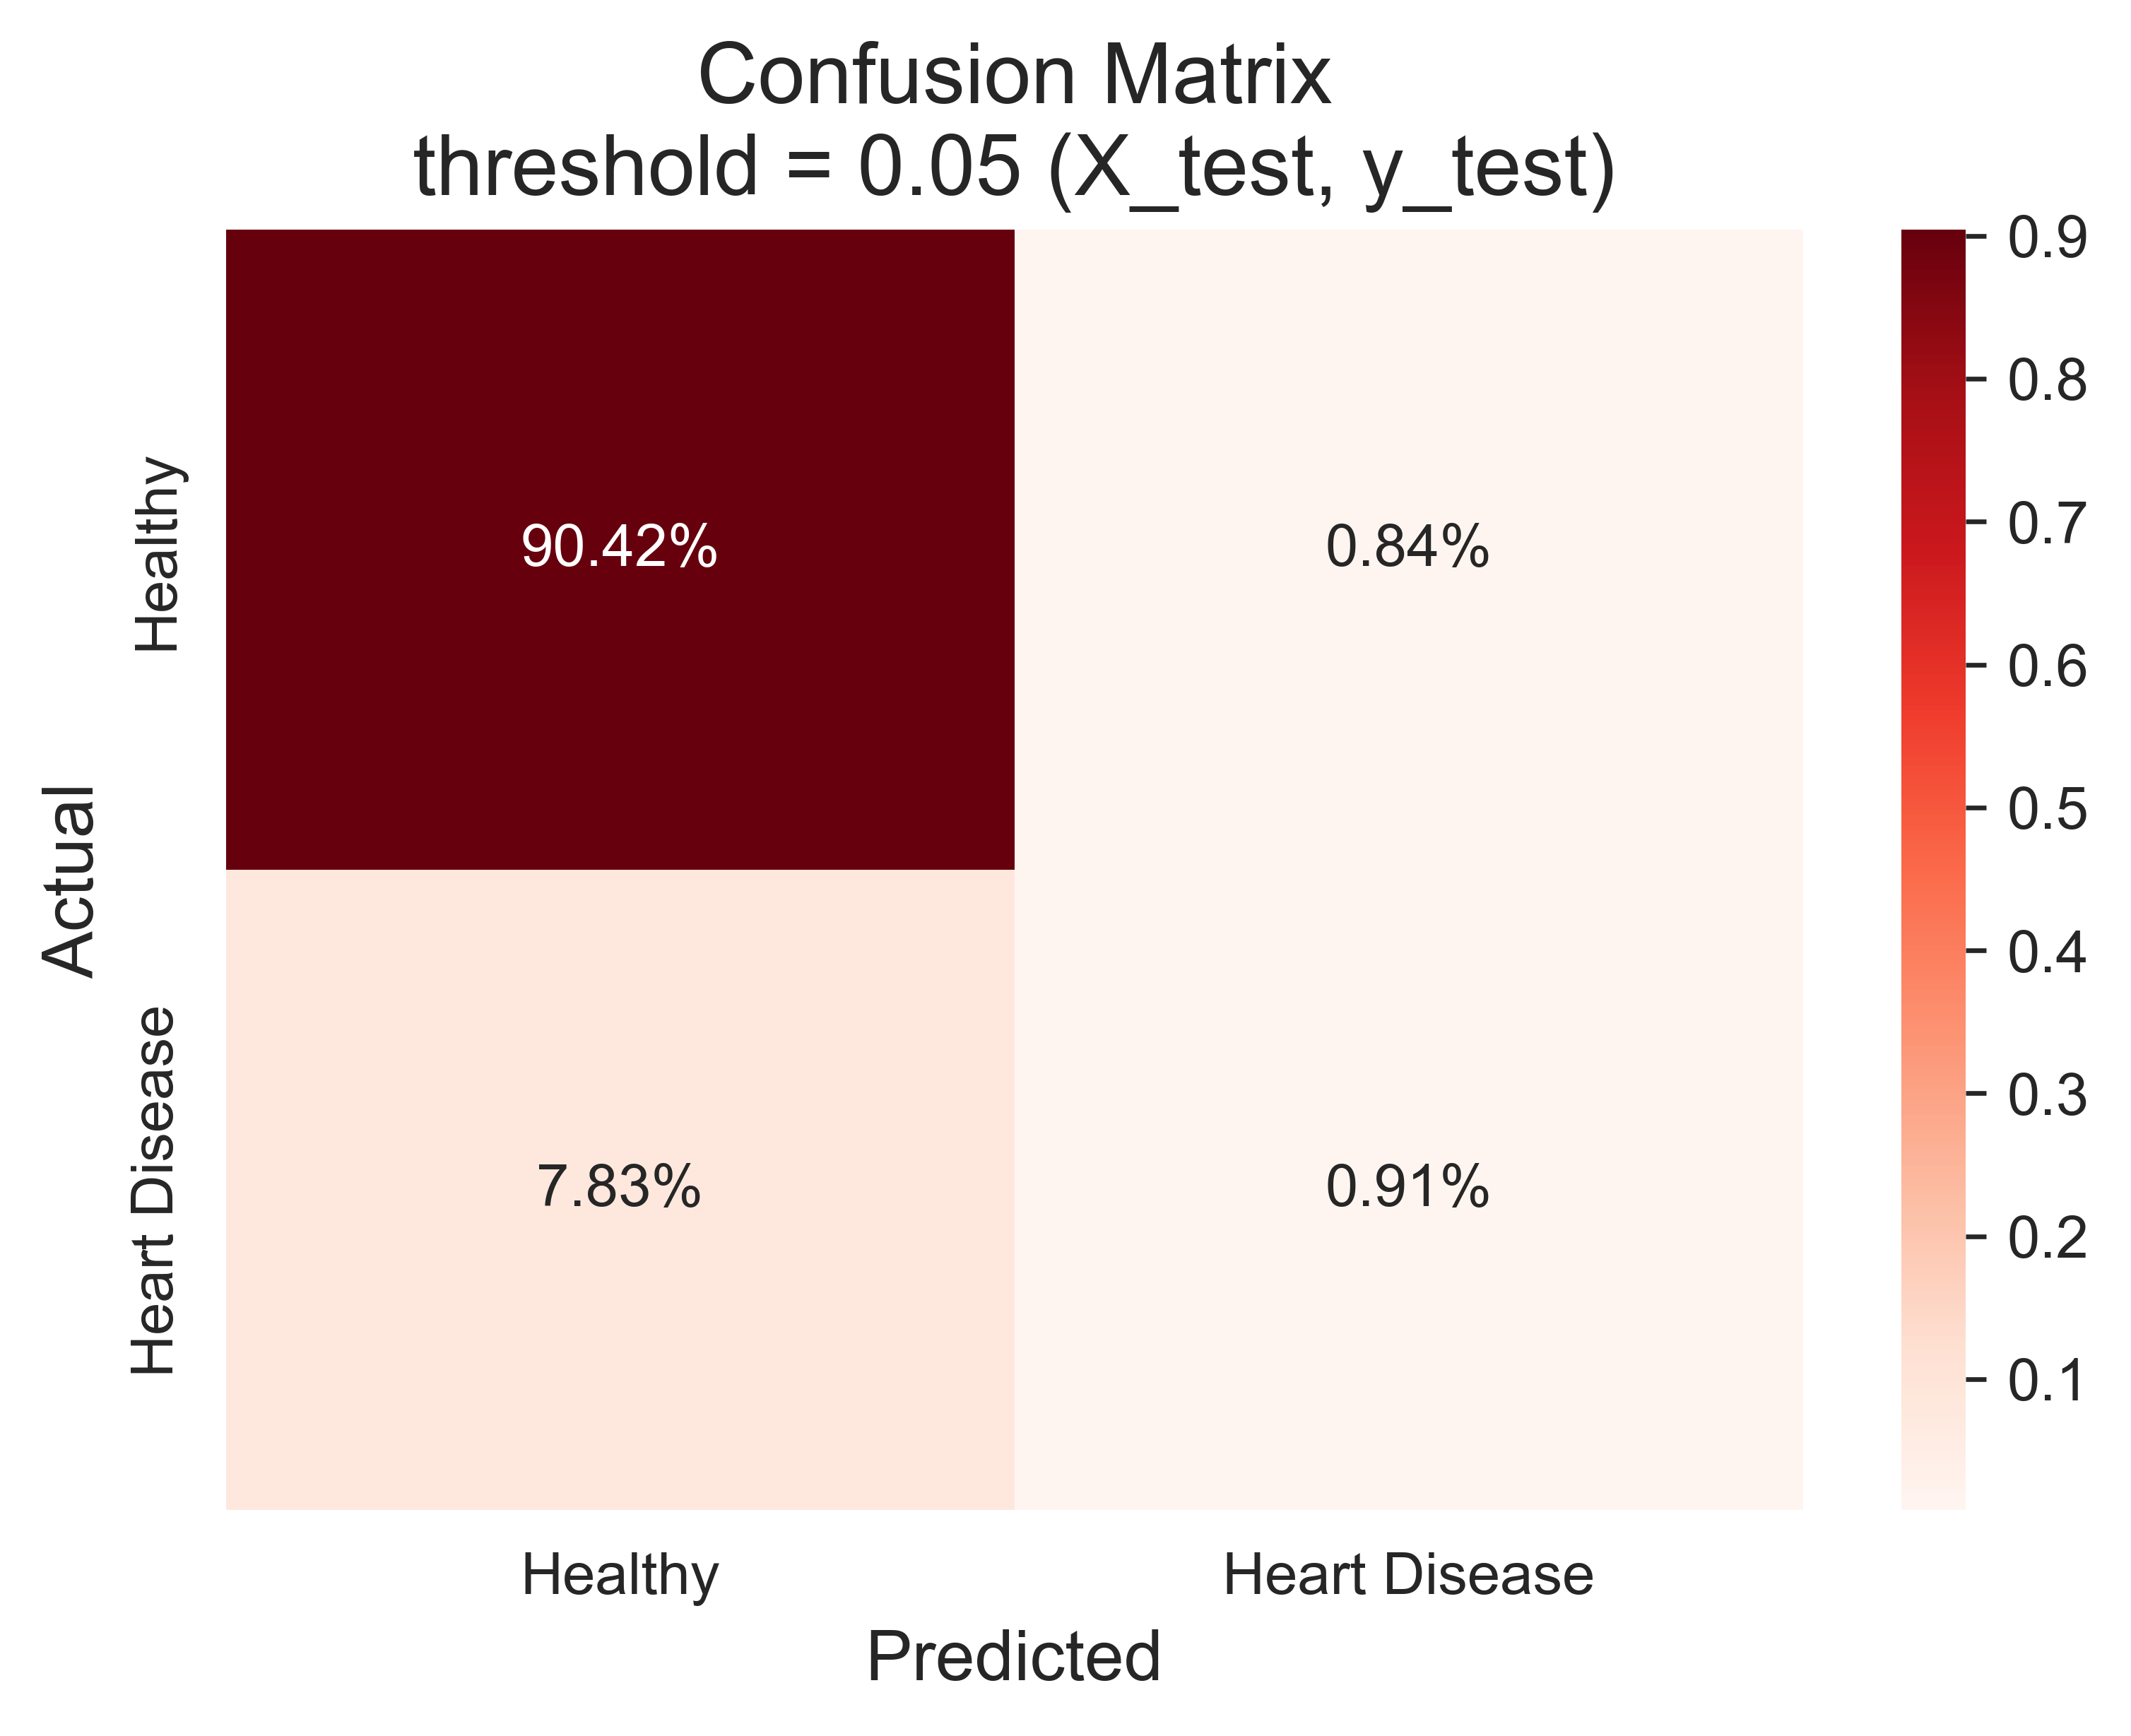

In [174]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600


ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')

ax.xaxis.set_ticklabels(['Healthy','Heart Disease'])
ax.yaxis.set_ticklabels(['Healthy','Heart Disease'])

plt.title('Confusion Matrix' '\n' 'threshold = 0.05 (X_test, y_test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual ')

plt.savefig("confusion-matrix.jpeg");


In [182]:
# classification report 
print(classification_report(y_test, y_pred) 
#                             final_model.predict(X_test_scaled), 
#                             target_names=['no heart disease', 'yes heart disease']

SyntaxError: unexpected EOF while parsing (4044066744.py, line 4)

In [179]:
classification_report


<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

[back to top](#top)

### 7.3 ROC AUC<a id='73'></a> 

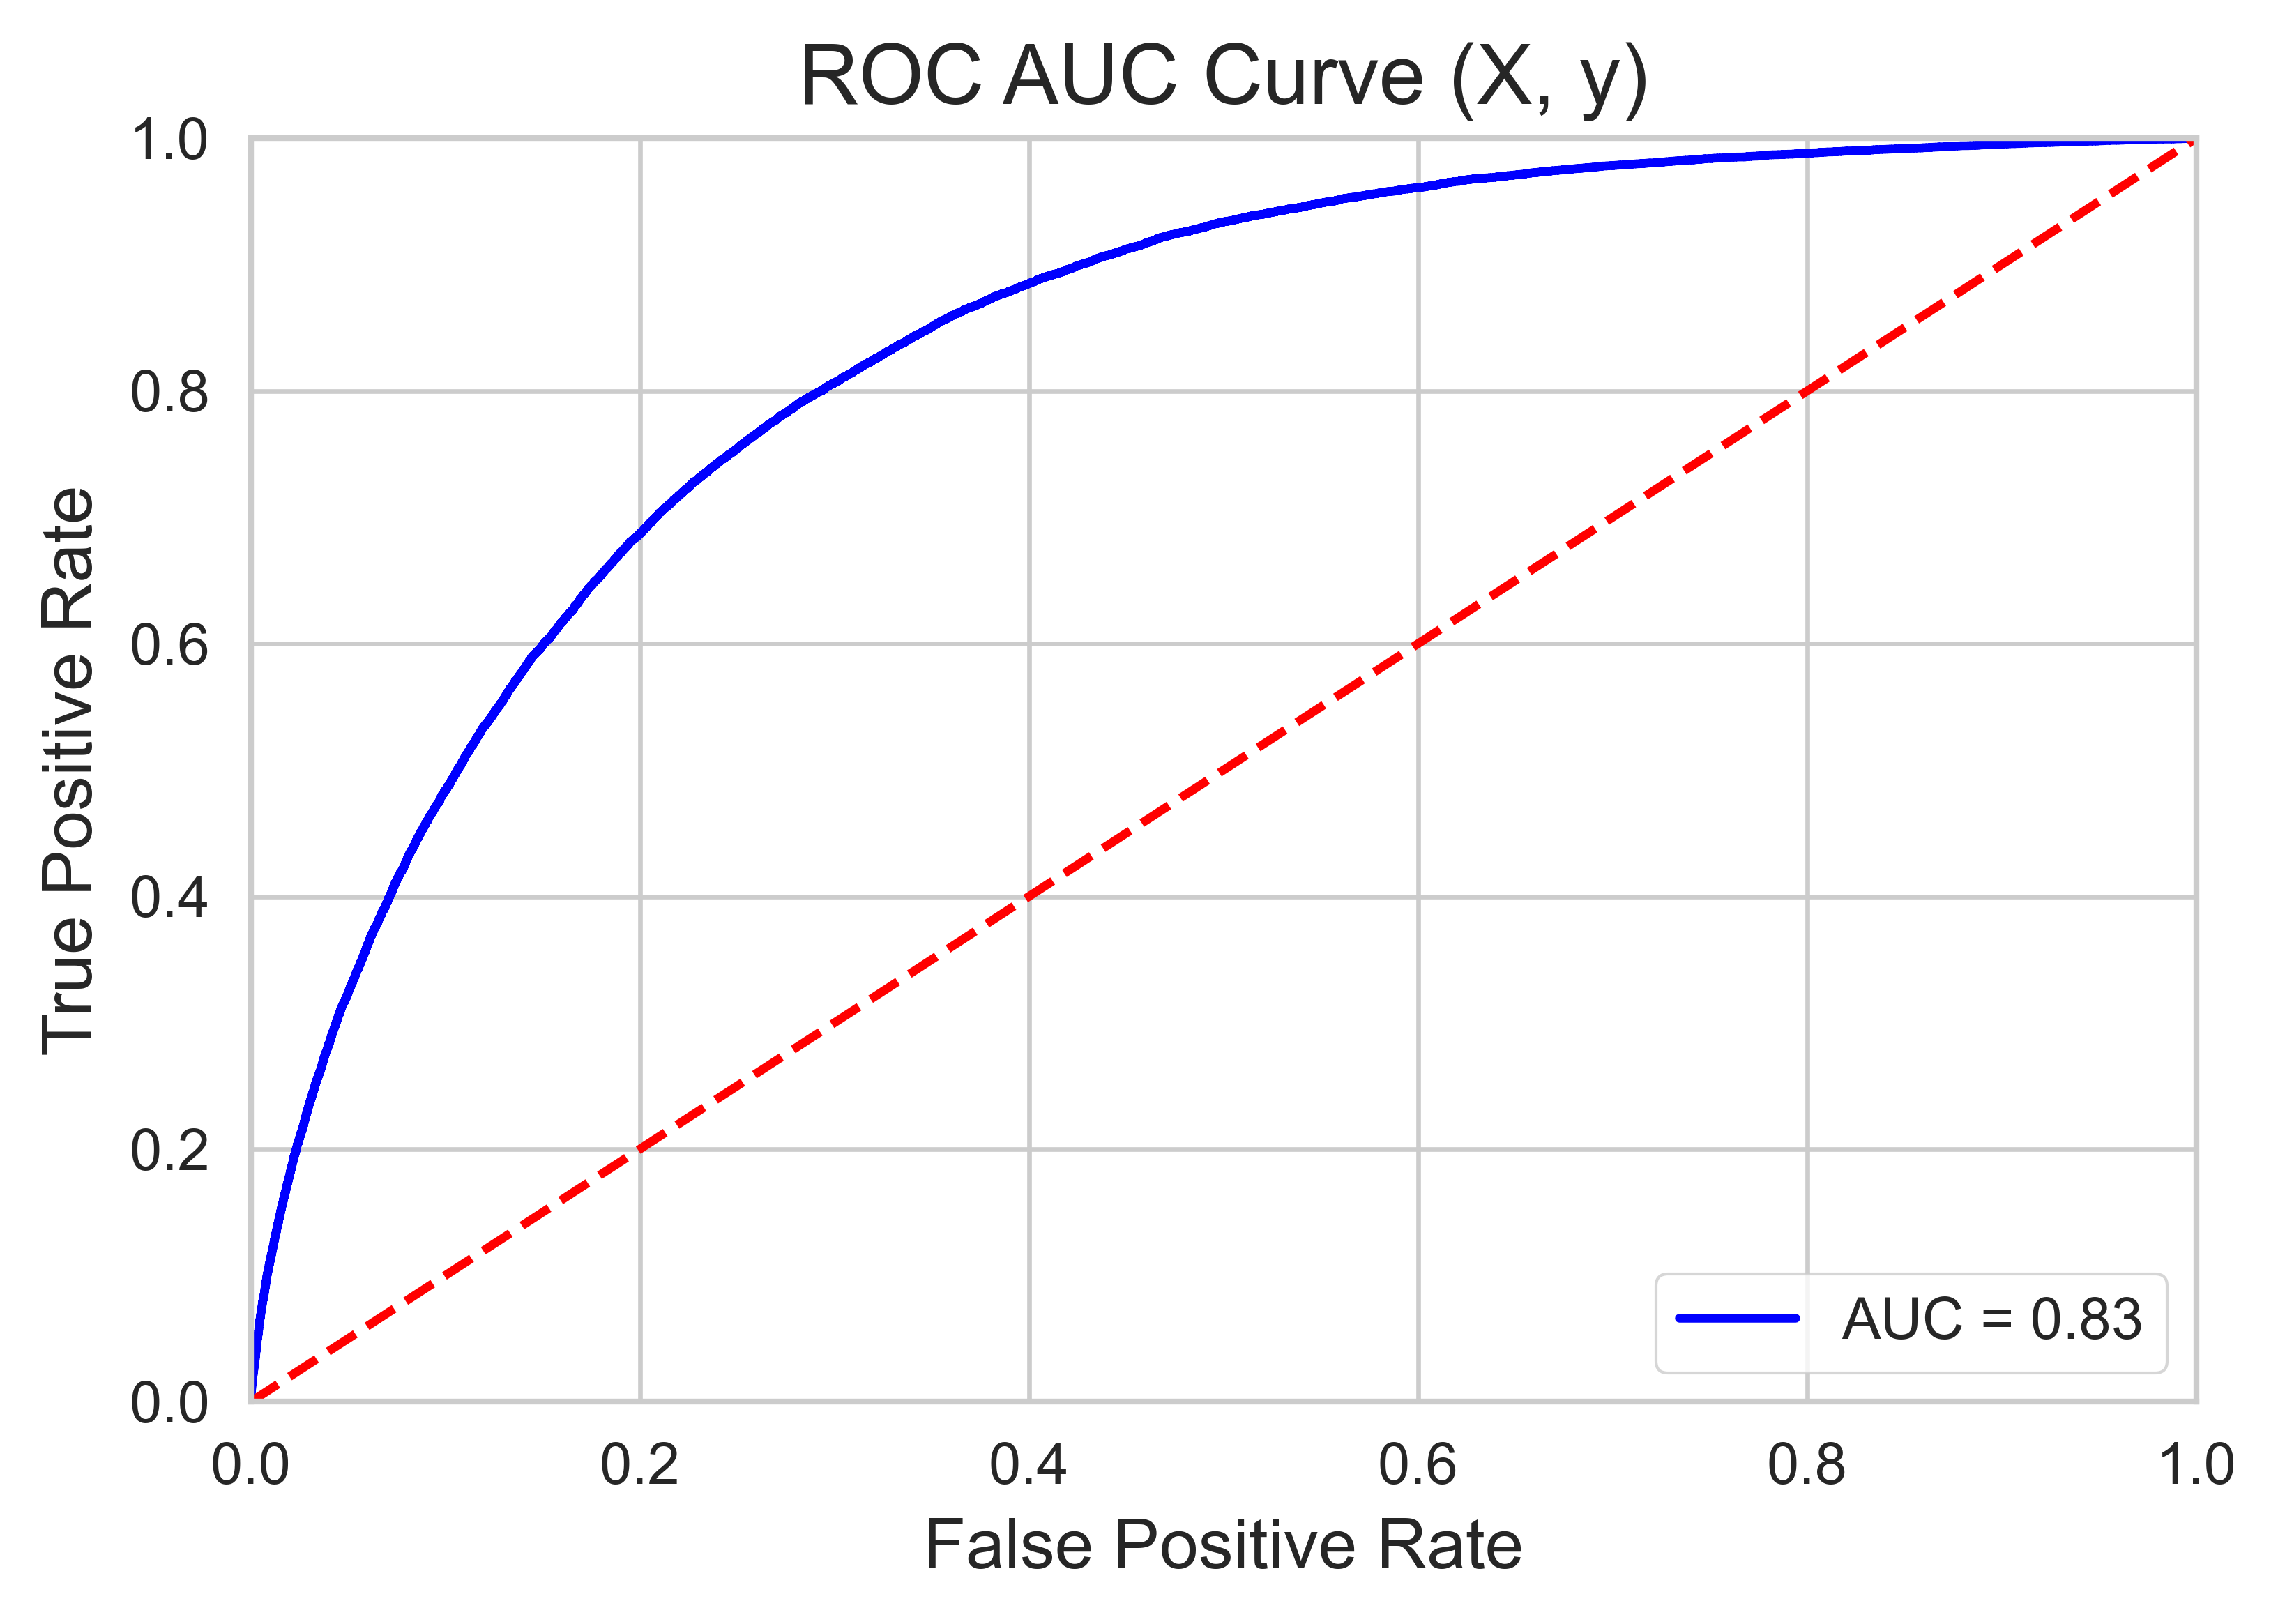

In [176]:
probs = final_model.predict_proba(X)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('ROC AUC Curve (X, y)')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("roc-auc-curve.jpeg");

[back to top](#top)

# ⚠️ replace with correlations
### 7.4 Feature Correlations<a id='74'></a> 

In [ ]:
# imp_feat = pd.DataFrame()
# feat = list(X)
# imp = final_model.coef_[0]
# imp_feat['Feature'] = feat
# imp_feat['Importance'] = imp
# imp_feat.sort_values(by=['Importance'], ascending=False, inplace=True)


In [ ]:
# # visualize feature importance
# plt.rcParams['figure.dpi'] = 600
# plt.rcParams['savefig.dpi'] = 600

# f, ax = plt.subplots(figsize=(12, 6))


# sns.barplot(x='Importance', y='Feature', data=imp_feat, color='red');
# plt.title('Feature Importance')

# plt.savefig("feature-importance.jpeg");


[back to top](#top)

### 7.5 Predictions<a id='75'></a> 

In [ ]:
# refit model to make predictions
heart_disease_model = LogisticRegression(C=0.01, penalty="l2")
heart_disease_model.fit(X_scaled, y)
y_pred = heart_disease_model.predict(X_scaled) 
# y_pred = (final_model.predict_proba(X_test)[:,1] > 0.05)

heart_disease_model

Value references in [data dictionary](#1a) and [MVP transformations](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb). 


~Top 4 important features: age, gender, stroke, tobacco, kidney~

In [ ]:
# 1: middle aged, man, smoker, no chronic disease

X_p1 = [[60,  #'demg_age'     middle aged
         2,  #'demg_gender'   male
         0, #'disease_stroke'
         1, #'behavior_tobacco' smoker
         0, #'disease_kidney'
         
         # rest of features will remain constant
         1, #'behavior_activity' works out regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'  
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi 
         3, #'health_general' health is good 
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p1 = heart_disease_model.predict(X_p1) 
y_pred_p_p1 = heart_disease_model.predict_proba(X_p1) 
print('Patient #1: middle aged, man, smoker, no chronic disease')
print('Yes/No heart disease:', y_pred_p1)
print('Probability of heart disease:', y_pred_p_p1)


In [ ]:
# 2: senior, female, stroke, smoker, kidney disease

X_p2 = [[80,  #'demg_age'     senior
         1,  #'demg_gender'   female
         1, #'disease_stroke' stroke
         1, #'behavior_tobacco' smoker
         1, #'disease_kidney'    kidney disease

         # rest of features will remain constant
         1, #'behavior_activity' works out regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'  
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi 
         3, #'health_general' health is good 
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p2 = heart_disease_model.predict(X_p2) 
y_pred_p_p2 = heart_disease_model.predict_proba(X_p2) 
print('Patient # 2: senior, female, stroke, smoker, kidney disease')
print('Yes/No heart disease:', y_pred_p2)
print('Probability of heart disease:', y_pred_p_p2)


In [ ]:
# 3: senior, man, not smoker, kidney disease

X_p3 = [[85,  #'demg_age'     senior
         1,  #'demg_gender'   male
         0, #'behavior_tobacco' not smoker
         0, #'disease_stroke' stroke
         1, #'disease_kidney' kidney disease

         # rest of features will remain constant
         1, #'behavior_activity' works out regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'  
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi 
         3, #'health_general' health is good 
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p3 = heart_disease_model.predict(X_p3) 
y_pred_p_p3 = heart_disease_model.predict_proba(X_p3) 
print('Patient #3: senior, man, not smoker, kidney disease')
print('Yes/No heart disease:', y_pred_p3)
print('Probability of heart disease:', y_pred_p_p3)


[back to top](#top)